<a href="https://colab.research.google.com/github/eduardodut/Analise-tweets-ICD-Unifor/blob/master/AnaliseTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carregamento e leitura dos dados a partir do repositório localizado em https://github.com/eduardodut/Analise-tweets-ICD-Unifor

In [103]:
import pandas as pd
import pickle
#função que realiza o download dos arquivos json
def carregarDados():
  import json
  import pandas as pd

  #download dos arquivos localizados no reposítório do projeto
  !curl --remote-name \
      -H 'Accept: application/vnd.github.v3.raw' \
      --location https://raw.githubusercontent.com/eduardodut/Analise-tweets-ICD-Unifor/master/Dados/LulaOficial.json


  !curl --remote-name \
      -H 'Accept: application/vnd.github.v3.raw' \
      --location https://raw.githubusercontent.com/eduardodut/Analise-tweets-ICD-Unifor/master/Dados/jairbolsonaro.json     

  #transformação dos arquivos json em datasets
  dataset_lula = pd.DataFrame()
  #tweetsLula = pd.read_json('/content/LulaOficial.json', lines = True)
  with open('/content/LulaOficial.json') as lula_file:
    dados = json.load(lula_file)
    dataset_lula = pd.DataFrame(dados)


  dataset_bolso = pd.DataFrame()
  #tweetsLula = pd.read_json('/content/LulaOficial.json', lines = True)
  with open('/content/jairbolsonaro.json') as bolso_file:
    dados = json.load(bolso_file)
    dataset_bolso = pd.DataFrame(dados)

  return dataset_bolso, dataset_lula

#utilização da função definida acima
dataset_bolso, dataset_lula = carregarDados()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.6M  100 47.6M    0     0  31.9M      0  0:00:01  0:00:01 --:--:-- 31.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.9M  100 25.9M    0     0  24.2M      0  0:00:01  0:00:01 --:--:-- 24.2M


1ª etapa de limpeza de dados:

*   Foco nas características quantitativas
*   Criação de novas features a partir das informações do dataset
*   Exclusão de features desnecessárias ou sem utilidade para a análise



In [0]:
import numpy as np

def cleaning_data(dataset):

  #realiza cópia do dataset
  dataset_temp = dataset.copy()
  
  #conversão da coluna 'created_at' para formato de data
  dataset_temp['created_at'] = dataset_temp['created_at'].astype('datetime64[ns]')
  # dataset_temp['created_at'] = pd.to_datetime(dataset_temp['created_at'])
  #criação da coluna 'caracter_count' a partir da coluna 'display_text_range', que indica o tamanho do tweet
  dataset_temp['character_count'] = [(dataset_temp['display_text_range'][i][1]-dataset_temp['display_text_range'][i][0] + 1)for i in range(0,dataset_temp.shape[0])]

  #função que extrai dados do dicionário da coluna 'user' e transforma em uma coluna do dataset
  def extracao_dados_user(coluna):
    if coluna not in dataset_temp.columns:
      dataset_temp[coluna] = [pd.DataFrame(dataset_temp['user']).loc[i][0].get(coluna) for i in range(0,dataset_temp.shape[0])]

  #função que extrai as hashtags e @ da coluna entities e as coloca em sua própria cluna, em forma de lista
  def extracao_entities():
         
    coluna_hashtags = []
    coluna_user_mentions = []

    for i in range(0,dataset_temp.shape[0]):
      list_hashtags = []
      list_user_mention = []
      if dataset_temp.loc[i]['entities'].get("hashtags") != None:
        for j in range(0,len(dataset_temp.loc[i]['entities'].get("hashtags"))):
          list_hashtags.append(dataset_temp.loc[i]['entities'].get("hashtags")[j].get('text'))
      coluna_hashtags.append(list_hashtags)

      if dataset_temp.loc[i]['entities'].get("user_mentions") != None:
        for j in range(0,len(dataset_temp.loc[i]['entities'].get("user_mentions"))):
         list_user_mention.append(dataset_temp.loc[i]['entities'].get("user_mentions")[j].get('name'))
      coluna_user_mentions.append(list_user_mention)

    dataset_temp['hashtags'] = coluna_hashtags
    dataset_temp['user_mentions'] = coluna_user_mentions

  extracao_entities()
  #colunas para remoção do dataset
  colunas_para_remocao = ['id_str', 'truncated','index', 'display_text_range', 'entities', 'lang',
                                   'source', 'in_reply_to_status_id','in_reply_to_status_id_str',
                                   'in_reply_to_user_id','in_reply_to_user_id_str', 'in_reply_to_screen_name',
                                   'user','geo','coordinates', 'place', 'contributors', 'is_quote_status',
                                   'possibly_sensitive', 'quoted_status_id','quoted_status_id_str',
                                  'quoted_status_permalink', 'extended_entities', 'quoted_status']
  #remoção das colunas
  dataset_temp = dataset_temp.sort_values('created_at', ascending = True).reset_index().drop(colunas_para_remocao, axis = 1)
  #reindexação do dataframe
  

  
  
  return dataset_temp


#chamada da função de limpeza inicial dos dados
bolso_data = cleaning_data(dataset_bolso)
lula_data = cleaning_data(dataset_lula)

#instanciamento das variaveis que representaram o dataset filtrado por data de cada usuario
bolsonaro_filtrado = bolso_data
lula_filtrado = lula_data

#verificação da data inicial e da data final do período que se tem dados
data_inicial_geral = np.min([bolso_data.loc[0,'created_at'],lula_data.loc[0,'created_at']])
data_final_geral = np.max([bolso_data.loc[bolso_data.shape[0]-1,'created_at'],lula_data.loc[lula_data.shape[0]-1,'created_at']])

#instanciação do dicionario com datas e eventos relevantes para a análise
dict_datas_relevantes = {data_inicial_geral.strftime('%Y.%m.%d'):"Data inicial do dataset",
                          '2016-08-31':"Fim do processo de impeachment de Dilma",
                          '2017-07-12':'Condenação do lula em 1ª instância',
                          '2018-01-24':'Confirmação da condenação pela 2 instância',
                          '2018-04-07':"Prisão de lula",
                          '2018-07-22':'Confirmação da candidatura do Bolsonaro',
                          '2018-10-07':'1º turno das eleições 2018',
                          '2018-10-28':'2º turno das eleições 2018',
                          '2019-11-08':'Soltura de lula',
                          data_final_geral.strftime('%Y.%m.%d'):"Data final do dataset"}

datas_relevantes = pd.DataFrame(dict_datas_relevantes.items(), columns=["Data","Evento"])
datas_relevantes['Data'] = datas_relevantes['Data'].astype('datetime64[ns]')
# datas_relevantes['Data'] = pd.to_datetime(datas_relevantes['Data'])
         

Selecionados  14961  dos  14961  tweets do lula
Selecionados  6794  dos  6794  tweets do Bolsonaro


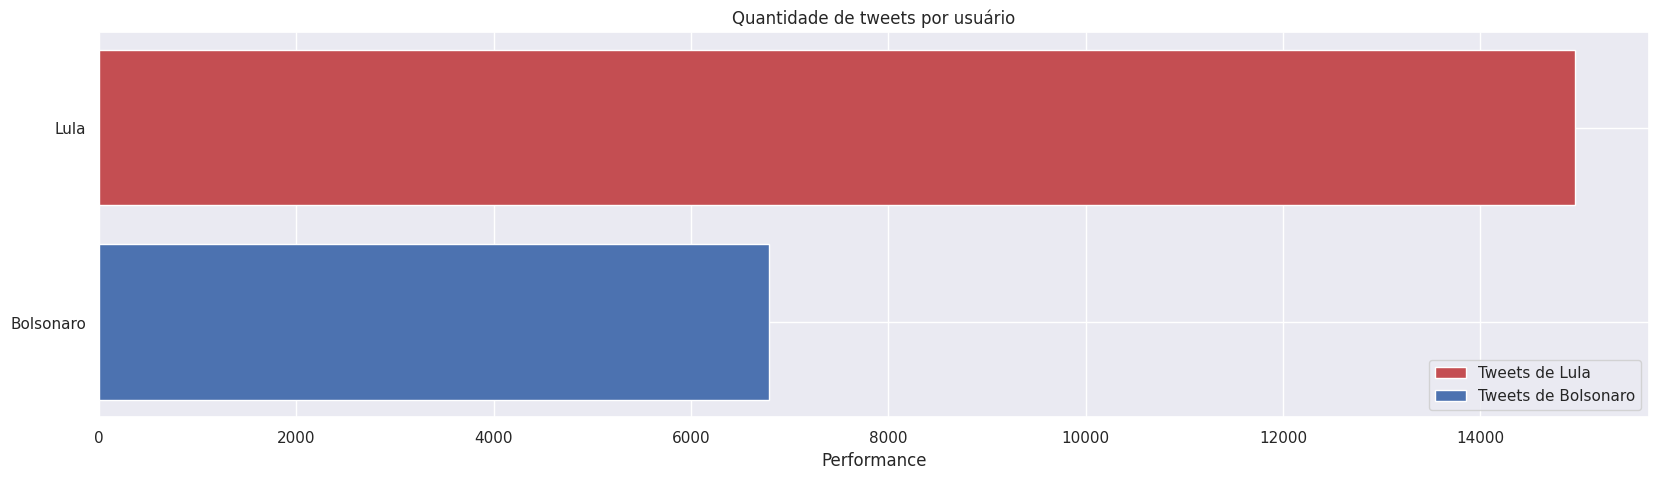

In [297]:
#@title Filtro de tempo para as análises e gráficos

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#@markdown Seleção opcional para período de análise 

datas_relevantes = pd.DataFrame(dict_datas_relevantes.items(), columns=["Data","Evento"])
datas_relevantes['Data'] = datas_relevantes['Data'].astype('datetime64[ns]')
data_inicial_analise = '2010-04-24'  #@param {type: "date"}
data_final_analise = '2011-01-08'  #@param {type: "date"}

#@markdown Os usuários abaixo terão seus tweets selecionados de acordo com as datas acima para análise

Lula = False #@param {type:"boolean"}
Bolsonaro = False #@param {type:"boolean"}

# data_inicial_analise = data_inicial_analise.join('00:00:00+00:00')
# data_final_analise = data_final_analise.join('00:00:00+00:00')

dic_datas_analise = {data_inicial_analise:"Data inicial da análise",
                     data_final_analise:"Data final da análise"}

datas_analise = pd.DataFrame(dic_datas_analise.items(), columns=datas_relevantes.columns)
datas_analise['Data'] = datas_analise['Data'].astype('datetime64[ns]')
# datas_analise['Data'] = pd.to_datetime(datas_analise['Data'])

dados_filtrados = Lula or Bolsonaro

if dados_filtrados:
  datas_relevantes = datas_relevantes.append(datas_analise).sort_values("Data")

col_data=[data_inicial_analise, data_final_analise]
datas = pd.DataFrame(col_data, columns=['data'])

datas = datas.data.astype('datetime64[ns]')
# datas = pd.to_datetime(datas.data)
if Bolsonaro:
  bolsonaro_filtrado = bolso_data.loc[bolso_data['created_at']>datas[0]]
  bolsonaro_filtrado = bolsonaro_filtrado.loc[bolsonaro_filtrado['created_at']<datas[1]]
else:
  bolsonaro_filtrado = bolso_data

if Lula :
  lula_filtrado = lula_data.loc[lula_data['created_at']>datas[0]]
  lula_filtrado = lula_filtrado.loc[lula_filtrado['created_at']<datas[1]]
else:
  lula_filtrado = lula_data


print("Selecionados ",lula_filtrado.shape[0], ' dos ',lula_data.shape[0]," tweets do lula")
print("Selecionados ",bolsonaro_filtrado.shape[0], ' dos ',bolso_data.shape[0]," tweets do Bolsonaro")


sns.set()
lula = ["Lula", 
        lula_filtrado.shape[0],
        lula_data.shape[0]-lula_filtrado.shape[0]]
bolso = ["Bolsonaro",
         bolsonaro_filtrado.shape[0],
         bolso_data.shape[0]-bolsonaro_filtrado.shape[0]]

dados = pd.DataFrame([lula,bolso], 
                    columns= ['usuario',
                              'tweets_selecionados',
                              'tweets_totais'])

# plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = dados.usuario
y_pos = np.arange(len(people))
performance = dados.tweets_selecionados
error = np.random.rand(len(people))
#barra do bolsonaro

lista_legenda = []

ax.barh(0, dados.tweets_selecionados.loc[dados.usuario=='Lula'],  align='center',color='#c44e52')
if Lula and dados.tweets_totais.loc[dados.usuario=='Lula'].values[0]>0:
  ax.barh(0, dados.tweets_totais.loc[dados.usuario=='Lula'],  align='center',color='#d16266',left = dados.tweets_selecionados.loc[dados.usuario=='Lula'])
  lista_legenda.append('Tweets selecionados de Lula')
  lista_legenda.append('Tweets não selecionados de Lula')
else:
  lista_legenda.append('Tweets de Lula')



ax.barh(1, dados.tweets_selecionados.loc[dados.usuario=='Bolsonaro'],  align='center',color='#4c72b0')

if Bolsonaro and dados.tweets_totais.loc[dados.usuario=='Bolsonaro'].values[0]>0:
  ax.barh(1, dados.tweets_totais.loc[dados.usuario=='Bolsonaro'],  align='center',color='#5d8cd9',left = dados.tweets_selecionados.loc[dados.usuario=='Bolsonaro'])
  lista_legenda.append('Tweets selecionados de Bolsonaro')
  lista_legenda.append('Tweets não selecionados de Bolsonaro')
else:
  lista_legenda.append('Tweets de Bolsonaro')




ax.set_yticks(y_pos)
ax.set_yticklabels(dados.usuario)
ax.invert_yaxis()  
ax.set_xlabel('Performance')
ax.set_title('Quantidade de tweets por usuário')
fig.set_size_inches(20,5)
plt.legend(lista_legenda)
plt.show()

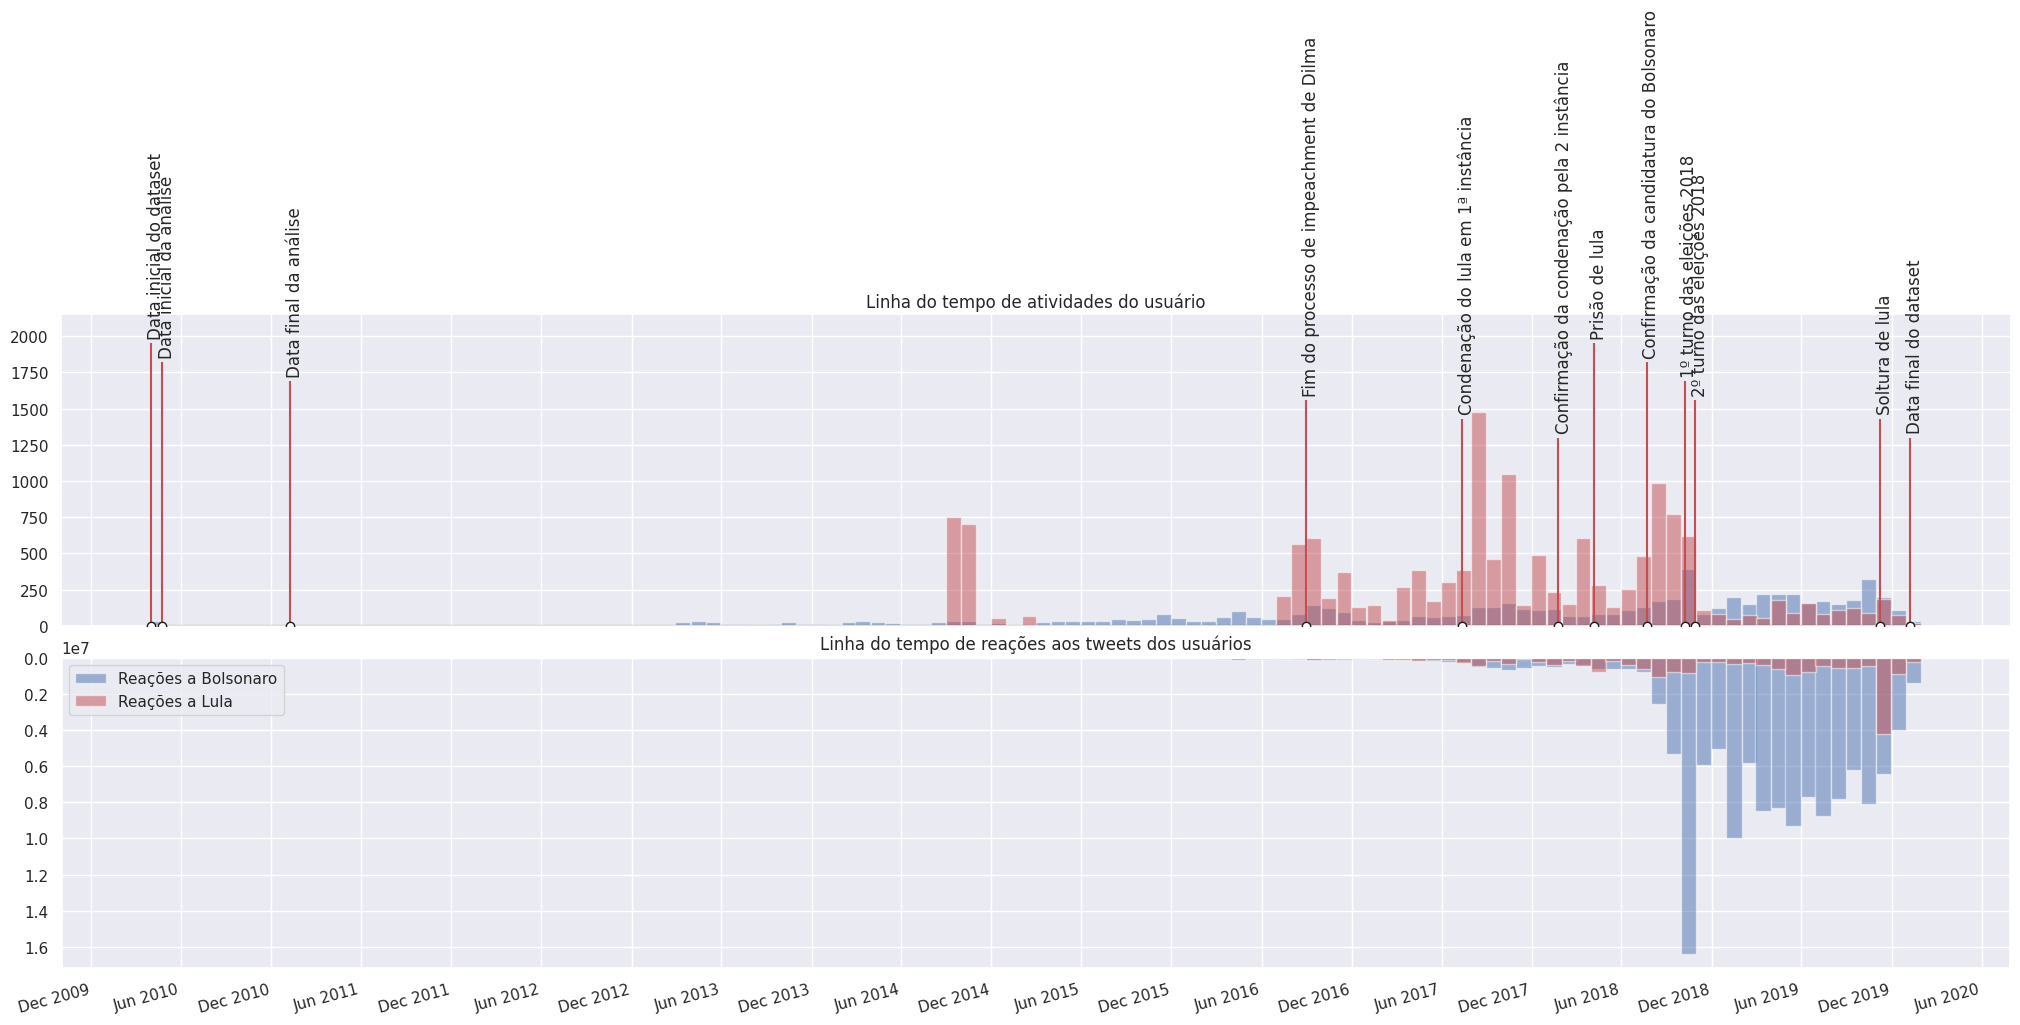

In [229]:
#@title Linha geral do tempo
#@markdown Visualização em gráfico da atividade dos dois políticos ao longo do período abrangido pelos datasets de entrada.

#@markdown Cada barra contém o acumulado mensal de tweets emitidos por cada usuário

#@markdown O gráfico contém anotações de alguns eventos políticos ocorridos para que se tenha uma ideia da atividade dos perfis em questão.

#@markdown Além dos eventos políticos o gráfico contém a anotação das datas escolhidas pelo usuário na célula acima.

escala_log_grafico_superior = False #@param {type:"boolean"}
escala_log_grafico_inferior = False #@param {type:"boolean"}
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
sns.set()
eventos = datas_relevantes['Evento']

dates = datas_relevantes['Data']

# Create figure and plot a stem plot with the date
fig, (ax,ax1) = plt.subplots(2,1,sharex=True)
ax.set(title="Linha do tempo de atividades do usuário")

levels = np.tile([1.5, 1.4, 1.3,1.2,1.1,1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]*1300



markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)
plt.setp(markerline, mec="k", mfc="w", zorder=3)



# format xaxis with 6 month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=6))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=15, ha="right")

# remove y axis and spines
#ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

# weekly = lula_data['created_at'].resample('W').sum()

def ajuste_dataset_grafico(dataset):
  df = pd.DataFrame(dataset["created_at"].groupby([dataset["created_at"].dt.year,dataset["created_at"].dt.month]).count())
  df.columns = ['Count']
  df = df.reset_index(level=1)
  df.columns = ['Mes','Count']
  df = df.reset_index(level=0)
  df.columns = ['Ano', 'Mes','Count']
  df['datetime'] =pd.to_datetime( dict(year=df.Ano, month=df.Mes, day=15))
  df['datetime'] = df['datetime'].astype('datetime64[ns]')
  return df

b = ajuste_dataset_grafico(bolso_data)
l = ajuste_dataset_grafico(lula_data)
larguraBarra= 30
# ax.bar(x=b["datetime"],height=b['Count'],width=larguraBarra,color='b', alpha=0.5)
# ax.bar(x=l["datetime"],height=l['Count'],width=larguraBarra,color='r', alpha=0.5)

ax.bar(x=b["datetime"],height=b['Count'],width = larguraBarra, color='b', alpha=0.5)
ax.bar(x=l["datetime"],height=l['Count'],width = larguraBarra, color='r', alpha=0.5)

# levels = np.tile([6,5, 4,3,2,1],
#                  int(np.ceil(len(dates)/6)))[:len(dates)]



# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(dates)))
plt.legend(['Evento político','Bolsonaro','Lula'])
# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, eventos, vert):
    
    
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="left", rotation=90)

ax1.set(title="Linha do tempo de reações aos tweets dos usuários")


def ajuste_dataset_dataset_grafico_reacoes(dataset,colunas):

  col = colunas.copy()
  col.insert(0,'created_at')
  data = dataset[col].groupby([dataset["created_at"].dt.year,dataset["created_at"].dt.month]).sum()
  data = data.reset_index(level=1)
  col = colunas.copy()
  col.insert(0,'Mes')
  data.columns = col.copy()
  data = data.reset_index(level=0)
  col.insert(0,'Ano')
  data.columns = col.copy()
  data['datetime'] = pd.to_datetime( dict(year=data.Ano, month=data.Mes, day=15))
  data['datetime'] = data['datetime'].astype('datetime64[ns]')

  return data
colunas = ['retweet_count','favorite_count']
b = ajuste_dataset_dataset_grafico_reacoes(bolso_data,colunas)
l = ajuste_dataset_dataset_grafico_reacoes(lula_data,colunas)
# print(l.head())
larguraBarra= 31
ax1.bar(x=b["datetime"],height=b[colunas[0]]+b[colunas[1]],width = larguraBarra, color='b', alpha=0.5)
ax1.bar(x=l["datetime"],height=l[colunas[0]]+l[colunas[1]],width = larguraBarra, color='r', alpha=0.5)

plt.legend(['Reações a Bolsonaro','Reações a Lula'])

ax1.invert_yaxis()
ax1.set_yscale('log')
ax.set_yscale('log')
if escala_log_grafico_superior:
  ax.set_yscale('log')
else:
  ax.set_yscale('linear')
if escala_log_grafico_inferior :
  ax1.set_yscale('log')
else:
  ax1.set_yscale('linear')


# ax.set_xmargin(0.1)


ax1.get_xaxis().set_major_locator(mdates.MonthLocator(interval=6))
ax1.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax1.get_xticklabels(), rotation=15, ha="right")

# ax1.set_yscale()

ax.margins(y=0.1)
fig.set_size_inches(20,10)
fig.tight_layout(pad=0.0)
plt.show()

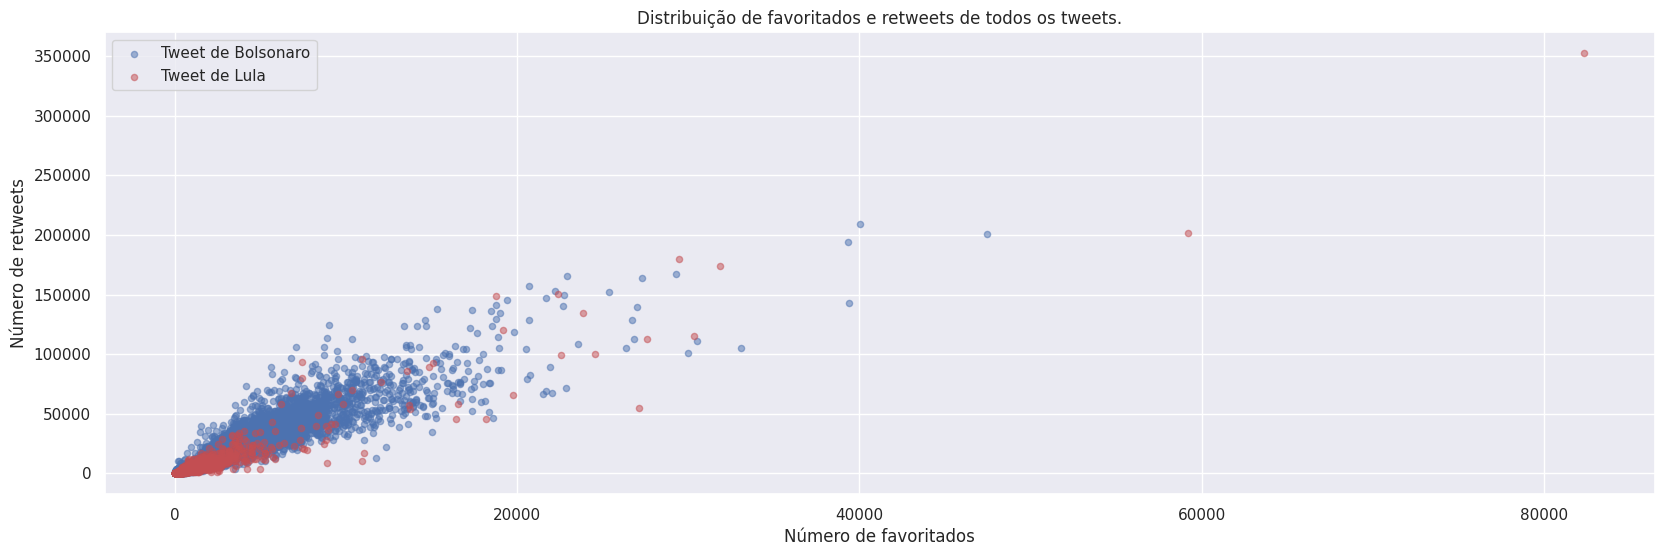

In [298]:
#@title Análise de dispersão das reações
#@markdown Visualização em gráfico de dispersão de quantidade de 'retweets' e quantidade de 'favoritado'. Os pontos azuis representam os tweets de Bolsonaro e os vermelhos representam os tweets de lula

#@markdown Por se tratar de uma variável com alguns outliers é recomendado que se utilize uma escala logaritmica para sua representação. Entretanto ao utilizar a escala logaritmica perde-se o senso da diferença entre as reações aos tweets dos dois usuários.
escala_log = False #@param {type:"boolean"}
#uso do estilo do seaborn
fig, ax = plt.subplots()
if escala_log:
  ax.set_yscale('log')
  ax.set_xscale('log')
  ax.set_xlim(xmin=10,xmax=100000000)
  ax.set_ylim(ymin=10,ymax=100000000)
else:
  ax.set_yscale('linear')
  ax.set_xscale('linear')
sns.set()

somaB = bolsonaro_filtrado['favorite_count'] + bolsonaro_filtrado['retweet_count']
somaL = lula_filtrado['favorite_count'] + lula_filtrado['retweet_count']


if somaB.mean() >= somaL.mean():  
  ax.scatter(y= bolsonaro_filtrado['favorite_count'], x= bolsonaro_filtrado['retweet_count'], color = 'b',s=20,alpha=0.5)
  ax.scatter(y= lula_filtrado['favorite_count'], x= lula_filtrado['retweet_count'],  color = 'r',s=20,alpha=0.5)
  plt.legend(['Tweet de Bolsonaro','Tweet de Lula'])
else:
  ax.scatter(y= lula_filtrado['favorite_count'], x= lula_filtrado['retweet_count'],  color = 'r',s=20,alpha=0.5)
  ax.scatter(y= bolsonaro_filtrado['favorite_count'], x= bolsonaro_filtrado['retweet_count'], color = 'b',s=20,alpha=0.5)
  plt.legend(['Tweet de Lula','Tweet de Bolsonaro'])
# Set the x-axis label
ax.set_xlabel("Número de favoritados")

# Set the y-axis label
ax.set_ylabel("Número de retweets")
if dados_filtrados:
  ax.set_title(''.join(["Distribuição de favoritados e retweets no período de ", data_inicial_analise," a ", data_final_analise,"."]))
else:
  ax.set_title(''.join(["Distribuição de favoritados e retweets de todos os tweets."]))
# ax.set_xlim(0,350000)

fig.set_size_inches(20,6)

plt.show()

In [312]:
stopwords = sw.words('portuguese')
[w for w in usuario_texto['textos_combinados'][0] if not w in stopwords]

['L',
 'u',
 'l',
 ' ',
 'c',
 'b',
 ' ',
 'd',
 ' ',
 'c',
 'h',
 'g',
 'r',
 ' ',
 ' ',
 '@',
 's',
 'm',
 'b',
 'c',
 ' ',
 'd',
 ' ',
 'n',
 'd',
 ' ',
 'c',
 'm',
 'ç',
 'r',
 'á',
 ' ',
 'c',
 'm',
 'i',
 'n',
 'h',
 'd',
 ' ',
 'j',
 'u',
 'n',
 't',
 ' ',
 'c',
 'm',
 ' ',
 '@',
 'd',
 'i',
 'l',
 'm',
 'b',
 'r',
 ' ',
 '#',
 'L',
 'u',
 'l',
 'D',
 'i',
 'l',
 'm',
 'n',
 'A',
 'B',
 'C',
 ' ',
 'A',
 'c',
 'm',
 'p',
 'n',
 'h',
 ' ',
 'n',
 't',
 'í',
 'c',
 'i',
 's',
 ' ',
 'd',
 ' ',
 'c',
 'm',
 'i',
 'n',
 'h',
 'd',
 ' ',
 't',
 'm',
 'b',
 'm',
 ' ',
 'p',
 'l',
 ' ',
 '@',
 'p',
 't',
 'b',
 'r',
 's',
 'i',
 'l',
 ' ',
 ' ',
 '@',
 'm',
 'u',
 'd',
 'm',
 'i',
 's',
 ' ',
 '#',
 'L',
 'u',
 'l',
 'D',
 'i',
 'l',
 'm',
 'n',
 'A',
 'B',
 'C',
 ' ',
 'L',
 'u',
 'l',
 ' ',
 'v',
 'i',
 's',
 'i',
 't',
 ' ',
 ' ',
 '@',
 's',
 'm',
 'b',
 'c',
 ' ',
 ' ',
 'c',
 'u',
 'm',
 'p',
 'r',
 'i',
 'm',
 'n',
 't',
 ' ',
 's',
 'i',
 'n',
 'd',
 'i',
 'c',
 'l',
 'i',
 's'

In [326]:
import re
import string
from nltk.corpus import stopwords as sw
from string import punctuation
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer
nltk.download("stopwords")  

def limpeza_texto(dataset):
  tweets = dataset.copy()
  # stopwords = sw.words('portuguese')
  #itera sobre o texto concatenado de todos os usuários
  for texto in tweets.textos_combinados:  
    #deixa todo texto em minúsculo
    texto = texto.lower()
    #remove os links
    re.
    texto = re.sub('^https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    texto = re.sub('^https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    texto = re.sub('\[.,!*?\]', '', texto)
    texto = re.sub('[%s]' % re.escape(string.punctuation), '', texto)
    texto = re.sub('\w*\d\w*', '', texto)
    texto = re.sub('[‘’“”…]', '', texto)
    texto = re.sub('\n', '', texto)
    print(texto)
        # '''Takes a list of text and combines them into one large chunk of text.'''
    # lista_tweets = []
    # for tweet in dataset:
    #   
    #   
    #   tweet = tweet.lower()
    #   lista_tweets.append(tweet)
    #  # Substituting multiple spaces with single space
    # #lista_tweets= re.sub(r'\s+', ' ', lista_tweets, flags=re.I)
    # #tknzr = TweetTokenizer()
    # #alltokens = tknzr.tokenize(lista_tweets)
    #   #lista_tweets = ' '.join([w for w in alltokens if not w in stopwords])
 
    return tweets

dict_usuario_texto = {"Lula":[' '.join(lula_data['full_text'].values)],
                      "Bolsonaro":[' '.join(bolso_data['full_text'].values)]}

usuario_texto = pd.DataFrame(dict_usuario_texto.values(),columns=['textos_combinados'])
usuario_texto = usuario_texto.transpose()
usuario_texto.columns=['Lula','Bolsonaro']
usuario_texto = usuario_texto.transpose()


usuario_texto = limpeza_texto(usuario_texto)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
lula acaba de chegar ao smabc de onde começará caminhada junto com dilmabr lulaedilmanoabc acompanhe notícias da caminhada também pelo ptbrasil e mudamais lulaedilmanoabc lula visita o smabc e cumprimenta sindicalistas e funcionários ao lado de dilmabr lulaedilmanoabc dilmabr e lula saem agora pelas ruas de são bernardo do campo e são saudados pela população lulaedilmanoabc os trabalhadores estão com dilmabr   diz o prefeito de são bernardo do campo luiz marinho marinhopt à população lulaedilmanoabc mais de  mil pessoas acompanham dilmabr e lula pelas ruas de são bernardo lulaedilmanoabc vocês geraram milhões de empregos no brasil diz marinhopt a dilmabr e lula lulaedilmanoabc este é o time que continuará transformando o  brasil finaliza marinhopt lulaedilmanoabc juruna da força sindical fala porque centrais estão com dilmabr ela vai trazer melhores condiçoes de vida p

In [317]:
usuario_texto['textos_combinados'][0]

'Lula acaba de chegar ao @smabc de onde começará caminhada junto com @dilmabr #LulaeDilmanoABC Acompanhe notícias da caminhada também pelo @ptbrasil e @mudamais #LulaeDilmanoABC Lula visita o @smabc e cumprimenta sindicalistas e funcionários ao lado de @dilmabr #LulaeDilmanoABC @dilmabr e Lula saem agora pelas ruas de São Bernardo do campo e são saudados pela população #LulaeDilmanoABC "Os trabalhadores estão com @dilmabr ",  diz o prefeito de São Bernardo do Campo, Luiz Marinho @marinhopt à população #LulaeDilmanoABC Mais de 2 mil pessoas acompanham @dilmabr e Lula pelas ruas de São Bernardo #LulaeDilmanoABC "Vocês geraram milhões de empregos no Brasil", diz @marinhopt a @dilmabr e Lula. #LulaeDilmaNoABC "Este é o time que continuará transformando o  Brasil", finaliza @marinhopt #LulaeDilmaNoABC Juruna, da Força Sindical, fala porque centrais estão com @dilmabr: "ela vai trazer melhores condiçoes de vida para o povo" #LulaeDilmaNoABC A caminhada segue pela Rua Marechal Deodoro rumo à 

In [0]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer  

def lista_top_words(lista_tweets):
  tfidfconverter = TfidfVectorizer(ngram_range= (1,1), stop_words=sw.words('portuguese'))  
  X = tfidfconverter.fit_transform(lista_tweets)

  tfidf_bolso = pd.DataFrame(X.toarray(), columns= tfidfconverter.get_feature_names())

  return pd.DataFrame(tfidf_bolso.sum().sort_values(ascending = False))

top_words_bolso = lista_top_words(texto_bolso)
top_words_lula = lista_top_words(texto_lula)

In [0]:
print(top_words_bolso.head())
print(top_words_lula.head())

In [276]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1,1))
data_cv = cv.fit_transform(usuario_texto.loc['Lula',:])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

data_dtm.transpose().sort_values(0, ascending= False)[:20]

,0
de,10678
que,9444
co,7329
https,7226
lula,5376
do,5161
não,4456
em,3979
da,3902
com,2886


In [260]:
cv = CountVectorizer(ngram_range=(1,1))
data_cv = cv.fit_transform([' '.join(lula_data['full_text'].values)])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

data_dtm.transpose().sort_values(0, ascending= False)[:20]

,0
de,10678
que,9444
co,7329
https,7226
lula,5376
do,5161
não,4456
em,3979
da,3902
com,2886


In [0]:
texto_lula.toarray()[0][2]

1

In [0]:
# Import the necessary modules




TypeError: ignored

In [0]:
alltokens

['lula',
 'acaba',
 'de',
 'chegar',
 'ao',
 'smabc',
 'de',
 'onde',
 'começará',
 'caminhada',
 'junto',
 'com',
 'dilmabr',
 'lulaedilmanoabc',
 'acompanhe',
 'notícias',
 'da',
 'caminhada',
 'também',
 'pelo',
 'ptbrasil',
 'e',
 'mudamais',
 'lulaedilmanoabc',
 'lula',
 'visita',
 'o',
 'smabc',
 'e',
 'cumprimenta',
 'sindicalistas',
 'e',
 'funcionários',
 'ao',
 'lado',
 'de',
 'dilmabr',
 'lulaedilmanoabc',
 'dilmabr',
 'e',
 'lula',
 'saem',
 'agora',
 'pelas',
 'ruas',
 'de',
 'são',
 'bernardo',
 'do',
 'campo',
 'e',
 'são',
 'saudados',
 'pela',
 'população',
 'lulaedilmanoabc',
 'os',
 'trabalhadores',
 'estão',
 'com',
 'dilmabr',
 'diz',
 'o',
 'prefeito',
 'de',
 'são',
 'bernardo',
 'do',
 'campo',
 'luiz',
 'marinho',
 'marinhopt',
 'à',
 'população',
 'lulaedilmanoabc',
 'mais',
 'de',
 'mil',
 'pessoas',
 'acompanham',
 'dilmabr',
 'e',
 'lula',
 'pelas',
 'ruas',
 'de',
 'são',
 'bernardo',
 'lulaedilmanoabc',
 'vocês',
 'geraram',
 'milhões',
 'de',
 'empregos'